To get started, we can perform linear regression using linear algebra. Assume a model of $y=\theta_0 + \theta_1 x_1 + \cdots + \theta_n x_n$, where $n$ is the number of features. $\theta_0$ is the bias term. The typical performance metric is mean square error (MSE): $E( \Theta )=\frac{1}{m}\sum_{i=1}^m (\Theta^T x^{(i)}-y^{(i)})$, where $\Theta = [\theta_0 \ \cdots \ \theta_n]$.

In [152]:
import numpy as np
import matplotlib.pyplot as plt

m = 500

X = 1.6 * np.random.rand(m,1)
y = 1.5 + 2.25 * X + np.random.randn(m,1) # theta_0 = 1.5, theta_1 = 2.25

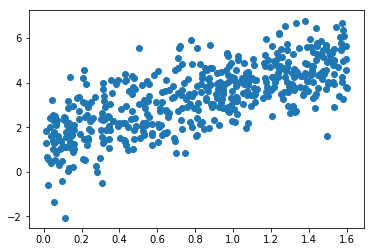

In [153]:
%matplotlib inline
plt.scatter(X,y)
plt.show()

By taking all data instances, $x^{(i)}$, and their target values, $y^{(i)}$, we can compute the parameters using the closed form equation:
$\hat{\Theta}=(X^T\cdot X)^{-1}\cdot X^T\cdot y$

In [154]:
X_b = np.c_[np.ones((500,1)), X] # Adds the bias term, x_0 = 1

In [155]:
theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [156]:
# We get something pretty close to the function that generated this data.
theta

array([[1.49932936],
       [2.24501046]])

In [157]:
# Test the predictions
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]

In [158]:
y_predict = X_new_b.dot(theta)
y_predict

array([[1.49932936],
       [5.98935028]])

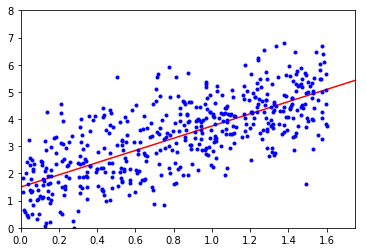

In [159]:
# Plot it
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0,1.75,0,8])
plt.show()

In [160]:
# We can do the same with sklearn linear regression.
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [161]:
print("Model: " + str(linreg.coef_) + "x + " + str(linreg.intercept_))

Model: [[2.24501046]]x + [1.49932936]


In [162]:
linreg.predict(X_new)

array([[1.49932936],
       [5.98935028]])

For data sets with a *large number of *features*, the inversion required to solve the equation becomes very expensive. Instead, *gradient descent* can be applied to adjust parameters, $\Theta$. In linear regression, MSE is the typical cost function. We compute the gradient of MSE along each parameter $\theta_j$. Gradient descent searches through the parameter space following the gradient of a convex function.

In [163]:
# Implementation of gradient descent
def gradient_descent(X, y, n_params, eta, tolerance):
    m = len(X)

    # Initialize the parameters to some random value
    theta = np.random.randn(n_params,1)
    # Compute an initial gradient vector
    gradient_vector = 2/m * X.T.dot(X.dot(theta) - y)
    
    while np.linalg.norm(gradient_vector) > tolerance:
        # Compute the gradient
        gradient_vector = 2/m * X.T.dot(X.dot(theta) - y)
        theta = theta - eta * gradient_vector

    return theta

In [164]:
params = gradient_descent(X_b, y, 2, 0.1, 0.001)
print("Final parameters:\n " + str(params))

Final parameters:
 [[1.49670871]
 [2.24780004]]


Nice!

Gradient descent requires the *whole training* set to compute the gradient. This requirement will not scale as the number of instances, $m$, increases. The alternative is to use **stochastic gradient descent**. We lose the smooth convergence guarantees and it will not reach the true optimal value. But, it executes on data point at a time, sometimes allowing quicker convergence to something near the minimum. It is recommended to apply simulated annealing (gradually reduce the step size/learning rate) as you approach the minimum. One approach, shown below, is to set a schedule based on the number of epochs.

In [165]:
n_epochs = 50
t0, t1 = 5, 50 # For the learning schedule

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # again, random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_idx = np.random.randint(m)
        # Slices out the entry at the random index
        xi = X_b[random_idx:random_idx+1]
        yi = y[random_idx:random_idx+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

print("Final parameters:\n " + str(theta))

Final parameters:
 [[1.50339069]
 [2.26929387]]


To handle large data sets, we can use mini-batch gradient descent. It snags a random subset of the data and performs a typical gradient descent operation with it. Note my implementation is not great! It does not converge, as shown in the plot.

In [166]:
from sklearn.utils import shuffle

n_epochs = 50
n_batches = 10
batch_size = m / n_batches

theta = np.random.randn(2,1)

eta = 0.01
gradient_norms = []
# For each epoch compute the gradient over the minibatch. Repeat for next batch.
for epoch in range(n_epochs):
    # Shuffle up the data sets and targets
    X_shuffle, y_shuffle = shuffle(X_b, y)        
    start_idx = 0
    stop_idx = int(batch_size - 1)
    for i in range(n_batches):
        X_batch = X_b[start_idx:stop_idx]
        y_batch = y[start_idx:stop_idx]
        gradients = 2 * X_batch.T.dot(X_batch.dot(theta) - y_batch)
        grad_norm = np.linalg.norm(gradients)
        gradient_norms.append(grad_norm)
        # Arbitrary, fixed schedule - it should be something nicer like
        # regular SGD, but anything higher than eta = 0.01 leads to instability
        if grad_norm < 100:
            eta = 0.005
        theta = theta - eta * gradients
        start_idx = int(stop_idx + 1)
        stop_idx = int(stop_idx + batch_size)

print("Final parameters:\n " + str(theta))

Final parameters:
 [[1.40449667]
 [2.2329094 ]]


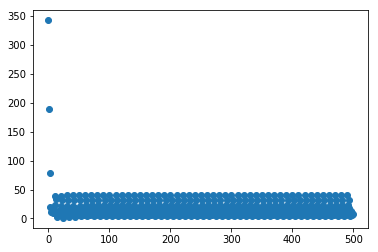

In [167]:
idxs = range(0,len(gradient_norms))
plt.scatter(idxs,gradient_norms)
plt.show()

Anywho - the lackluster attempt at mini-batch SGD distracted from polynomial regression! If the data is clearly nonlinear, the features can be manipulated to perform linear regression on polynomial basis functions.

In [173]:
X = 5 * np.random.rand(m, 1) - 3
y = 0.85 * X**2 + 3*X + 1 + np.random.randn(m,1)

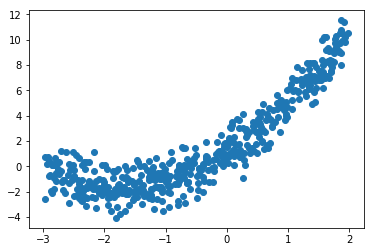

In [174]:
plt.scatter(X,y)
plt.show()

In [176]:
# Transform the features into polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [178]:
print("Original feature sample: " + str(X[0]))
print("...and it's 2nd order version: " + str(X_poly[0]))

Original feature sample: [-2.49771156]
...and it's 2nd order version: [-2.49771156  6.23856302]


In [179]:
# Simply apply linear regression now
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [180]:
print("Coefficients: " + str(lin_reg.coef_))
print("y-Intercept: " + str(lin_reg.intercept_))

Coefficients: [[3.03967949 0.87141614]]
y-Intercept: [1.0675911]


Also pretty good! Note that for data with multiple features, PolynomialFeatures will compute their combinations but that is a combinatoric process!